#### In this notebook:  
* we cross-validate Gamma Ray carotage models on 4 wells from the Netherlands Offshore F3 Block open project, https://terranubis.com/datainfo/Netherlands-Offshore-F3-Block-Complete  
* Dictionary `weights` provides list of 4 models ordered according to test folds. Every test fold associated with just one well -  F02-1, F03-2, F03-4, F06-1. Each of the wells is projected onto 42 nearest seismic slices (2 inlines/crosslines x 21 slices) 
* we average well carotage across multiple slices and calculate statistics  
* we visualize predictions: carotage for a single well and carotage for a whole seismic slice   

In [1]:
# reload modules automatically:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore')

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('.').absolute().parent / 'modules')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from keras import backend as K
from model1 import uResNet34
from data_gen1 import SliceIterator, primary_transform
from const import (
    data_dir,
    norm_dict_path, # narmalization dictionary for neural net
    log_dir, # processed well logs
    slices_dir, # path to generated training data
    model_dir, # path to models
    crossval_dict,  # 4-fold crossvalidation: 3 train, 1 test well
    wells,  # wells
    ilines, xlines, nsamples, dt # seismic cube parameters
)
from train_model import get_train_test_split

import numpy as np
import pandas as pd
import re
import cv2
import pickle
from shutil import copyfile
import segyio
from itertools import chain, islice
import matplotlib.pyplot as plt
import matplotlib.colors as colors

model_class = uResNet34
image_size = (480, 512)

with open(norm_dict_path, 'rb') as f:
    norm_dict = pickle.load(f)
cv_dataset = get_train_test_split(slices_dir, crossval_dict)

Using TensorFlow backend.


In [2]:
# trained models in the order of cv test folds
weights = {
    'Gamma_Ray': [
        'uResNet34.Gamma_Ray.sz480x512.smtd_0.14-0.78.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.smtd_1.11-0.37.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.smtd_2.07-0.65.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.smtd_3.42-0.67.hdf5'
    ],
}

In [3]:
def predict_on_fold(slice_list, carotage, model_weights, verbose=False):
    """predict model for a single fold"""
    
    norm = [(norm_dict[c]['mean'], norm_dict[c]['std']) for c in ['seismic', carotage]]

    K.clear_session()
    model = model_class(input_size=image_size, weights=model_weights, n_carotage=1)
    gen = SliceIterator(slice_list, [carotage], image_size, transform_fun=primary_transform, norm=norm, aug=False,
                        batch_size=10, shuffle=False, seed=None, verbose=False, output_ids=True, infinite_loop=False)
    x_m, y, ids = zip(*gen)
    x, m = zip(*x_m)
    x = np.concatenate(x)
    m = np.concatenate(m)
    y = np.concatenate(y)
    ids = list(chain(*ids))

    pred = model.predict([x, m], batch_size=4)

    data = []
    for seismic, mask, y_true, p, i_d in zip(x, m, y, pred, ids):
        designation_size = (max(ilines) - min(ilines) + 1, nsamples) if 'xline' in i_d else (max(xlines) - min(xlines) + 1, nsamples)
        y_pred = p[..., :1]

        seism = cv2.resize(seismic[..., 0], dsize=designation_size, interpolation=cv2.INTER_CUBIC)
        mask = cv2.resize(mask[..., 0], dsize=designation_size, interpolation=cv2.INTER_NEAREST)
        y_true = cv2.resize(y_true[..., 0], dsize=designation_size, interpolation=cv2.INTER_NEAREST)
        y_pred = cv2.resize(y_pred[..., 0], dsize=designation_size, interpolation=cv2.INTER_NEAREST)

        corr = np.corrcoef(y_true[mask.astype(bool)], y_pred[mask.astype(bool)])[0, 1]
        data.append({'seism': seism, 'mask': mask, 'y_true': y_true, 'y_pred': y_pred, 'corr': corr, 'id': i_d})
    if verbose:
        # "provisional" correlation based on single pixels. not used in final evaluation
        print(f'corr={np.mean([d["corr"] for d in data if ~np.isnan(d["corr"])])}')
    return data

In [4]:
def eval_fold(data, carotage):
    """returns list of fold correlations, plus true and predicted data for the fold"""
    
    mean, std = norm_dict[carotage]['mean'], norm_dict[carotage]['std']
    correlations = []
    viz_data = []
    for d in data:
        mask = d['mask'].astype(int)
        y_true = d['y_true']
        y_pred = d['y_pred']
        i_d = d['id']

        true_carotage = (y_true * mask).sum(1) / mask.sum(1) * std + mean
        pred_carotage = (y_pred * mask).sum(1) / mask.sum(1) * std + mean
        t = np.arange(len(y_true), dtype=float) * 2
        t = np.arange(nsamples, dtype=float) * dt
        t[mask.sum(1) == 0] = np.nan

        corr = np.corrcoef(true_carotage[~np.isnan(true_carotage)], pred_carotage[~np.isnan(pred_carotage)])[0, 1]
        correlations.append(corr)

        viz_data.append({'i_d': i_d, 't': t, 'true_carotage': true_carotage, 'pred_carotage': pred_carotage, 'corr': corr})
    
    correlations = np.array(correlations)
    correlations = correlations[~np.isnan(correlations)]
    return correlations, viz_data

In [5]:
def process_all_folds(carotage):
    """process all folds for a given carotage type and return all fold correlations plus true and predicted data
    print correlation averaged for all slices in a fold"""
    
    folds = range(len(cv_dataset))
    all_fold_correlation, all_viz = [], []
    for fold in folds:
        model_weights =  model_dir / weights[carotage][fold]
        slice_list = cv_dataset[fold]['test']
        data = predict_on_fold(slice_list, carotage, model_weights, verbose=False)
        correlations, viz_data = eval_fold(data, carotage)
        print('fold:', fold, 'corr:', np.mean(correlations))
        all_fold_correlation.extend(correlations)
        all_viz.extend(viz_data)
    return all_fold_correlation, all_viz

### Evaluate models for Gamma Ray carotage

In [6]:
eval_dict = {}
for c in ['Gamma_Ray']:
    all_fold_correlation, all_viz = process_all_folds(c)
    eval_dict[c] = {}
    eval_dict[c]['corr'] = all_fold_correlation
    eval_dict[c]['viz'] = all_viz

W0530 00:24:28.654999  6284 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Load weights from f:\Sandbox\ml-recipe-seismic\models\smoothed\uResNet34.Gamma_Ray.sz480x512.smtd_0.14-0.78.hdf5


[Run:AI] [DEBUG   ] [30-05-2020 00:24:36.449] [4488] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0530 00:24:36.449999  6284 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps
W0530 00:24:36.465999  6284 deprecation.py:323] From f:\Sandbox\ml-recipe-seismic\modules\model1.py:88: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0530 00:24:37.884000  6284 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



fold: 0 corr: 0.8150348274004667
Load weights from f:\Sandbox\ml-recipe-seismic\models\smoothed\uResNet34.Gamma_Ray.sz480x512.smtd_1.11-0.37.hdf5


[Run:AI] [DEBUG   ] [30-05-2020 00:24:51.766] [4488] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0530 00:24:51.766999  6284 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 1 corr: 0.47117723848568316
Load weights from f:\Sandbox\ml-recipe-seismic\models\smoothed\uResNet34.Gamma_Ray.sz480x512.smtd_2.07-0.65.hdf5


[Run:AI] [DEBUG   ] [30-05-2020 00:25:04.264] [4488] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0530 00:25:04.264999  6284 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 2 corr: 0.6842219990819423
Load weights from f:\Sandbox\ml-recipe-seismic\models\smoothed\uResNet34.Gamma_Ray.sz480x512.smtd_3.42-0.67.hdf5


[Run:AI] [DEBUG   ] [30-05-2020 00:25:16.588] [4488] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0530 00:25:16.588000  6284 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 3 corr: 0.7348497847361788


#### Average predicted carotage for a well across all slices associated with this well

In [7]:
mean_eval_dict = {}
all_corr = []
for w in wells:
    mean_eval_dict[w] = {}
    for slice_type in ['iline', 'xline']:
        t = next(i['t'] for i in eval_dict['Gamma_Ray']['viz'] if (w in i['i_d']) and (slice_type in i['i_d']))
        true_carotage = next(i['true_carotage'] for i in eval_dict['Gamma_Ray']['viz'] if (w in i['i_d']) and (slice_type in i['i_d']))
        pred_carotage = [i['pred_carotage'] for i in eval_dict['Gamma_Ray']['viz'] if (w in i['i_d']) and (slice_type in i['i_d'])]
        pred_carotage = np.stack(pred_carotage).mean(0)
        corr = np.corrcoef(true_carotage[~np.isnan(true_carotage)], pred_carotage[~np.isnan(pred_carotage)])[0, 1]
        print(f'well {w}, {slice_type}, corr={corr:0.2f}')
        all_corr.append(corr)
        mean_eval_dict[w][slice_type] = {}
        mean_eval_dict[w][slice_type]['t'] = t
        mean_eval_dict[w][slice_type]['true_carotage'] = true_carotage
        mean_eval_dict[w][slice_type]['pred_carotage'] = pred_carotage
        mean_eval_dict[w][slice_type]['corr'] = corr
        
print(f'\nOverall correlation: {np.array(all_corr).mean():0.2f}')

well F02-1, iline, corr=0.89
well F02-1, xline, corr=0.85
well F03-2, iline, corr=0.68
well F03-2, xline, corr=0.62
well F03-4, iline, corr=0.75
well F03-4, xline, corr=0.84
well F06-1, iline, corr=0.81
well F06-1, xline, corr=0.78

Overall correlation: 0.78


### Visualize

#### Predicted results distribution across all slices

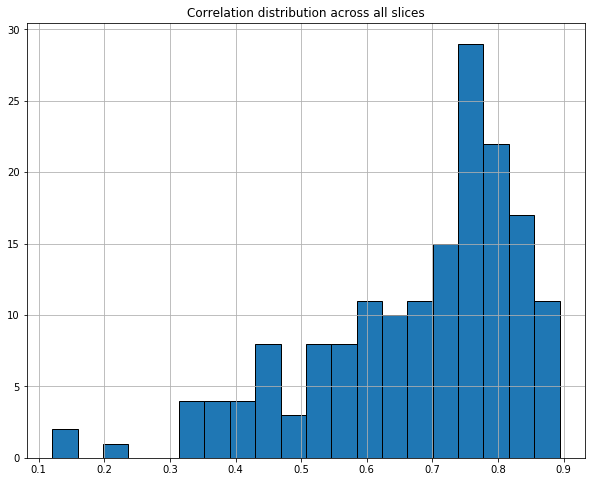

In [8]:
fig = plt.figure(figsize=(10, 8))
plt.hist(eval_dict['Gamma_Ray']['corr'], bins=20, edgecolor='black', linewidth=1.0)
plt.grid('on')
plt.title('Correlation distribution across all slices')
plt.show()

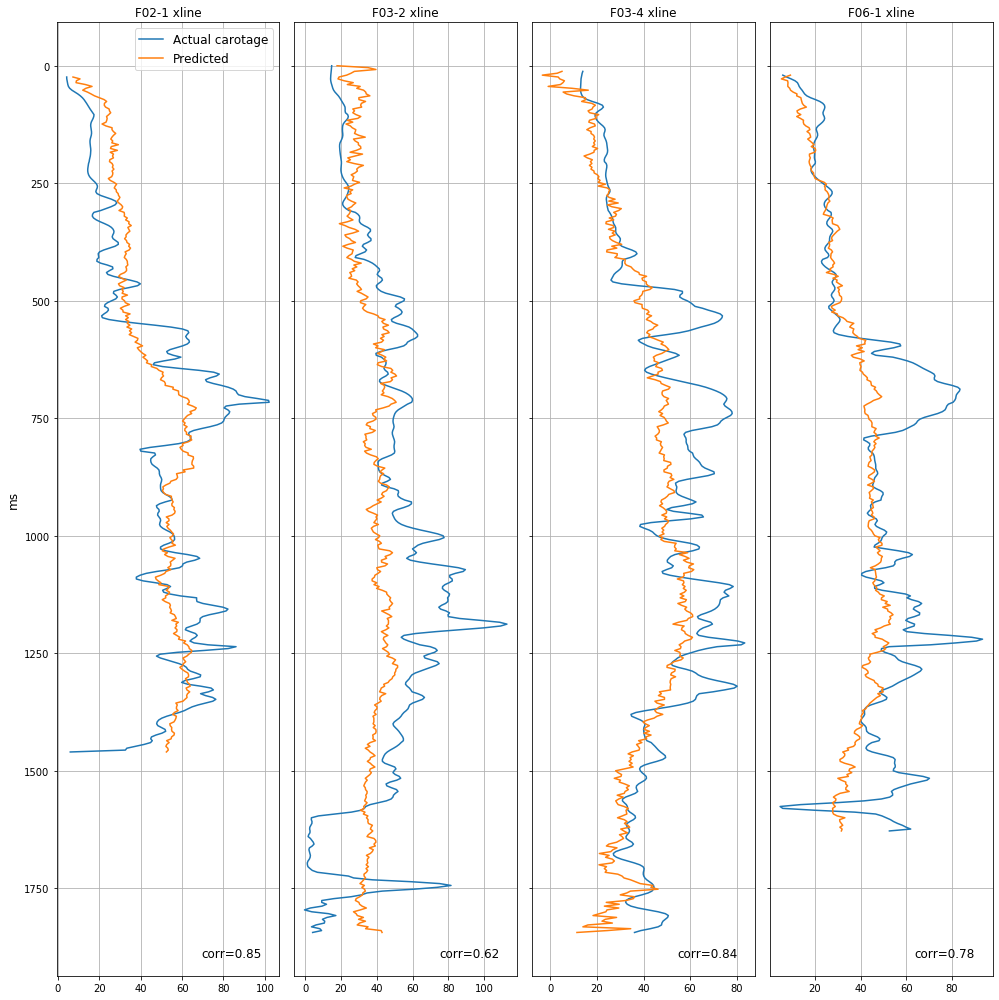

In [9]:
fontsize = 12
slice_type = 'xline'
fig, ax = plt.subplots(1, 4, figsize=(14, 14), sharey=True)

for i, (w, ax_) in enumerate(zip(wells, ax.flatten())):
    t = mean_eval_dict[w][slice_type]['t']
    true_carotage = mean_eval_dict[w][slice_type]['true_carotage']
    pred_carotage = mean_eval_dict[w][slice_type]['pred_carotage']
    corr = mean_eval_dict[w][slice_type]['corr']
    ax_.plot(true_carotage, t, pred_carotage, t)
    ax_.set_title(r'{} {}'.format(w, slice_type), fontsize=fontsize)
    if i == 0:
        ax_.set_ylabel('ms', fontsize=fontsize)
        ax_.legend(['Actual carotage', 'Predicted'], fontsize=fontsize)
    ax_.text(0.65, 0.02, f'corr={corr:0.2f}', transform=ax_.transAxes, fontsize=fontsize)
    ax_.grid(True)
ax_.invert_yaxis()    
    
plt.tight_layout()
plt.show()

### Visualize predicted Gamma Ray carotage for a whole seismic slice  
#### well F02-1 is associated with test fold 0 and projected onto 42 nearest seismic slices; one of them - inline 363

In [10]:
fold = 0
slice_list = cv_dataset[fold]['test']
carotage = 'Gamma_Ray'
data = predict_on_fold(slice_list, carotage, model_dir / weights[carotage][fold], verbose=False)

Load weights from f:\Sandbox\ml-recipe-seismic\models\smoothed\uResNet34.Gamma_Ray.sz480x512.smtd_0.14-0.78.hdf5


[Run:AI] [DEBUG   ] [30-05-2020 00:25:32.536] [4488] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps
I0530 00:25:32.536999  6284 optimizers.py:16] Wrapping 'Adam' Keras optimizer with GA of 16 steps


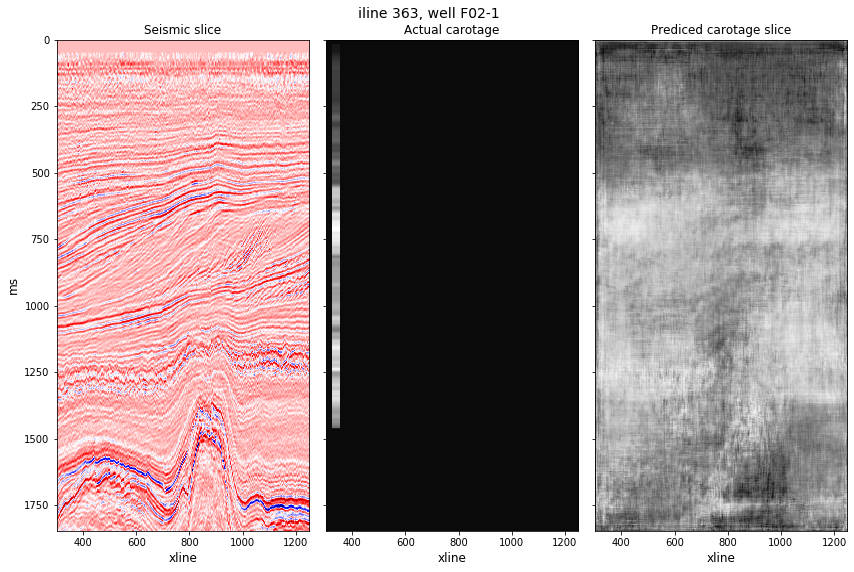

In [11]:
d = data[11]

color_norm = colors.Normalize(vmin=d['y_pred'].min(), vmax=d['y_pred'].max())
extent = [min(ilines), max(ilines), nsamples * dt - 1, 0] if 'xline' in d['id'] else [min(xlines), max(xlines), nsamples * dt - 1, 0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
ax1.imshow(d['seism'], cmap='seismic', extent=extent)
ax1.set_title('Seismic slice')
ax1.set_ylabel('ms', fontsize=fontsize)
ax1.set_xlabel('iline' if 'xline' in d['id'] else 'xline', fontsize=fontsize)

ax2.imshow(d['y_true'], cmap='Greys_r', extent=extent, norm=color_norm)
ax2.set_title('Actual carotage')
ax2.set_xlabel('iline' if 'xline' in d['id'] else 'xline', fontsize=fontsize)

ax3.imshow(d['y_pred'], cmap='Greys_r', extent=extent, norm=color_norm)
ax3.set_title(f'Prediced carotage slice')
ax3.set_xlabel('iline' if 'xline' in d['id'] else 'xline', fontsize=fontsize)

plt.tight_layout()
plt.suptitle(f'{{}} {{}}, well {{}}'.format(*d['id'].split('_')), fontsize=14, y=0.99)
plt.show()